In [1]:
latent_space_dim = 100

from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

import torch.distributions as TD
from zmq import device
import torch.optim as optim
from datetime import datetime
import functools
from tqdm import tqdm

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

import torch.nn as nn

PCA_model = PCA(n_components=latent_space_dim)

class CTDataset(Dataset):
    def __init__(self, filepath):
        self.x, self.y = torch.load(filepath)
        self.x = self.x / 255.
        self.x = self.x.reshape(-1, 28*28).cuda().detach().cpu()
        self.x = torch.from_numpy(PCA_model.fit_transform(self.x)).to(device).float()
        self.y = F.one_hot(self.y, num_classes=10).to(float)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

class CTDataset_test(Dataset):
    def __init__(self, filepath):
        self.x, self.y = torch.load(filepath)
        self.x = self.x / 255.
        self.x = self.x.reshape(-1, 28*28).cuda().detach().cpu()
        self.x = torch.from_numpy(PCA_model.transform(self.x)).to(device).float()
        self.y = F.one_hot(self.y, num_classes=10).to(float)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]


def find_loss(y_torch, gen_y_all_torch, z_torch, sigma_w, sigma_u, M, dim_y):
    n = z_torch.shape[0]
    w_mx = torch.linalg.vector_norm(z_torch.repeat(n, 1, 1) - torch.swapaxes(z_torch.repeat(n, 1, 1), 0, 1), ord=1, dim=2)
    w_mx = torch.exp(-w_mx / sigma_w)

    u_mx_1 = torch.exp(-torch.linalg.vector_norm(y_torch.repeat(n, 1, 1) - torch.swapaxes(y_torch.repeat(n, 1, 1), 0, 1), ord=1, dim=2) / sigma_u)
    u_mx_2 = torch.mean(
        torch.exp(-torch.linalg.vector_norm(gen_y_all_torch.repeat(n, 1, 1).reshape(n, n, -1, dim_y) - y_torch.repeat(1, n).reshape(n, n, 1, dim_y), ord=1, dim=3) / sigma_u), dim=2)
    u_mx_3 = u_mx_2.T

    gen_y_all_torch_rep = gen_y_all_torch.repeat(n, 1, 1).reshape(n, n, -1, dim_y)
    temp_mx = torch.swapaxes(gen_y_all_torch_rep[:, :, 0, :], 0, 1)
    sum_mx = torch.mean(torch.exp(-torch.linalg.vector_norm(gen_y_all_torch_rep - temp_mx.reshape(n, n, 1, dim_y), ord=1, dim=3) / sigma_u), dim=2)

    for i in range(1, M):
        temp_mx = torch.swapaxes(gen_y_all_torch_rep[:, :, i, :], 0, 1)
        temp_add_mx = torch.mean(torch.exp(-torch.linalg.vector_norm(gen_y_all_torch_rep - temp_mx.reshape(n, n, 1, dim_y), ord=1, dim=3) / sigma_u), dim=2)
        sum_mx = sum_mx + temp_add_mx

    u_mx_4 = 1 / M * sum_mx
    u_mx = u_mx_1 - u_mx_2 - u_mx_3 + u_mx_4

    FF_mx = u_mx * w_mx * (1 - torch.eye(n).to(device))

    loss = 1 / (n) * torch.sum(FF_mx)
    return loss

##### GAN architecture #####

class Generator(torch.nn.Module):
    """
    Specify the neural network architecture of the Generator.

    Here, we consider a FNN with a fully connected hidden layer with a width of 50,
    which is followed by a Leaky ReLU activation. The coefficient of Leaky ReLU needs to be
    specified. Batch normalization may be added prior to the activation function.
    The output layer a fully connected layer without activation.

    Inputs:
    - input_dimension: Integer giving the dimension of input X.
    - output_dimension: Integer giving the dimension of output Y.
    - noise_dimension: Integer giving the dimension of random noise Z.
    - BN_type: 'True' or 'False' specifying whether batch normalization is included.
    - ReLU_coef: Scalar giving the coefficient of the Leaky ReLU layer.

    Returns:
    - x: PyTorch Tensor containing the (output_dimension,) output of the discriminator.
    """

    def __init__(self, input_dimension, output_dimension, noise_dimension, hidden_layer_size, BN_type, ReLU_coef, drop_out_p,
                 drop_input = False):
      super(Generator, self).__init__()
      self.BN_type = BN_type
      self.ReLU_coef = ReLU_coef
      self.fc1 = torch.nn.Linear(input_dimension + noise_dimension, hidden_layer_size, bias=True)
      if BN_type:
        self.BN1 = torch.nn.BatchNorm1d(hidden_layer_size, 0.8, affine=False)
        self.BN2 = torch.nn.BatchNorm1d(hidden_layer_size, 0.8, affine=False)
        self.BN3 = torch.nn.BatchNorm1d(hidden_layer_size, 0.8, affine=False)
      self.leakyReLU1 = torch.nn.LeakyReLU(ReLU_coef)
      self.fc2 = torch.nn.Linear(hidden_layer_size, hidden_layer_size, bias=True)
      self.fc3 = torch.nn.Linear(hidden_layer_size, hidden_layer_size, bias=True)
      self.fc_last = torch.nn.Linear(hidden_layer_size, output_dimension, bias=True)
      self.sigmoid = torch.nn.Sigmoid()
      self.drop_out0 = torch.nn.Dropout(p=drop_out_p)
      self.drop_out1 = torch.nn.Dropout(p=drop_out_p)
      self.drop_out2 = torch.nn.Dropout(p=drop_out_p)
      self.drop_out3 = torch.nn.Dropout(p=drop_out_p)
      self.drop_input = drop_input
      self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
      if self.BN_type:
        if self.drop_input:
            x = self.drop_out0(x)
        x = self.drop_out1(self.leakyReLU1(self.BN1(self.fc1(x))))
        x = self.drop_out2(self.leakyReLU1(self.BN2(self.fc2(x))))
        # x = self.drop_out3(self.leakyReLU1(self.BN3(self.fc3(x))))
        x = self.fc_last(x)
        x = self.softmax(x)
      else:
        if self.drop_input:
            x = self.drop_out0(x)
        x = self.drop_out1(self.leakyReLU1(self.fc1(x)))
        x = self.drop_out2(self.leakyReLU1(self.fc2(x)))
        # x = self.drop_out3(self.leakyReLU1(self.fc3(x)))
        x = self.fc_last(x)
        # x = self.sigmoid(x)
        x = self.softmax(x)

      return x


##### Auxilliary functions #####

def sample_noise(sample_size, noise_dimension, noise_type, input_var):
    """
    Generate a PyTorch Tensor of random noise from the specified reference distribution.

    Input:
    - sample_size: the sample size of noise to generate.
    - noise_dimension: the dimension of noise to generate.
    - noise_type: "normal", "unif" or "Cauchy", giving the reference distribution.

    Output:
    - A PyTorch Tensor of shape (sample_size, noise_dimension).
    """

    if (noise_type == "normal"):
      noise_generator = TD.MultivariateNormal(
        torch.zeros(noise_dimension).to(device), input_var * torch.eye(noise_dimension).to(device))

      Z = noise_generator.sample((sample_size,))
    if (noise_type == "unif"):
      Z = torch.rand(sample_size, noise_dimension)
    if (noise_type == "Cauchy"):
      Z = TD.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample((sample_size, noise_dimension)).squeeze(2)

    return Z

def train_label(DataLoader_test, train_ds, test_ds,
      noise_dimension, noise_type, G_lr, hidden_layer_size,
      DataLoader, BN_type, ReLU_coef,
      epochs_num=10,  sigma_z = 1, sigma_y = 1,
      lambda_1 = 1, wgt_decay = 0,
      lambda_3 = 0, drop_out_p = 0.2, M_train = 3, input_noise_var = 1./3.):
    """
    Train loop for GAN.

    Inputs:
    - X: PyTorch Tensor (sample_size, input_dimension) of training input.
    - Y: PyTorch Tensor (sample_size, output_dimension) of training output.
    - noise_dimension: Integer giving the dimension of random noise Z.
    - noise_type: "normal", "unif" or "Cauchy", giving the reference distribution.
    - D_lr, G_lr: Float giving the learning rate of the discriminator and
      the generator.
    - discriminator_type, generator_type: ("KL", "JS", "WS", "LS"), giving the loss criterion
      of the discriminator and generator, respectively.
    - discriminator_loss, generator_loss: Functions to use for computing the
      generator and discriminator loss, respectively.
    - DataLoader: DataLoader object used to generate training batches.
    - BN_type: 'True' or 'False' specifying whether batch normalization is included.
    - ReLU_coef: Scalar giving the coefficient of the Leaky ReLU layer.
    - batch_size: Integer giving the size of batches for each epoch.
    - epochs_num: Number of epochs over the training dataset to use for training.
    - lambda_gp: Float giving the coefficient of gradient penalty for WS.

    Outputs:
    - D: PyTorch Net giving the trained discriminator.
    - G: PyTorch Net giving the trained generator.
    - Output the trained D and G at 250, 500, 750, 1000 epochs.
    """

    input_dimension = latent_space_dim
    output_dimension_y = 10

    criterion = nn.CrossEntropyLoss() # for testing

    G_zy = Generator(input_dimension, output_dimension_y, noise_dimension, hidden_layer_size, BN_type, ReLU_coef, drop_out_p).to(device)
    G_zy_solver = optim.Adam(G_zy.parameters(), lr=G_lr, betas=(0.5, 0.999), weight_decay=wgt_decay)
    # G_zy_solver = optim.SGD(G_zy.parameters(), lr=G_lr, weight_decay=wgt_decay)

    scheduler = torch.optim.lr_scheduler.StepLR(G_zy_solver, step_size=20, gamma=0.1)

    batch_size_eval = 128
    DataLoader_eval = torch.utils.data.DataLoader(test_ds, batch_size=batch_size_eval, shuffle=False, drop_last= False)

    train_acc = 0.0

    G_zy = G_zy.eval()
    with torch.no_grad():
        mmd_loss = []
        acc_list = []

        running_loss = []
        for i, data in enumerate(DataLoader_eval, 0):
            Z_test, Y_test = data
            Z_test = Z_test.to(device)
            Y_test = Y_test.to(device)

            batch_size = Z_test.shape[0]
            Z_real_repeat = Z_test.repeat(M_train,1)
            # Generate fake data
            Noise_fake = sample_noise(Z_real_repeat.shape[0], noise_dimension, noise_type, input_var = input_noise_var).to(device)
            with torch.no_grad():
                Y_fake = G_zy(torch.cat((Z_real_repeat,Noise_fake),dim=1)).to(device)
            Y_fake = Y_fake.reshape(batch_size, M_train, output_dimension_y)
            loss = find_loss(Y_test, Y_fake, Z_test, sigma_z, sigma_y, M_train, output_dimension_y)
            running_loss.append(loss.item())

        running_loss_train = []
        for i, data in enumerate(DataLoader, 0):
            Z_test, Y_test = data
            Z_test = Z_test.to(device)
            Y_test = Y_test.to(device)

            batch_size = Z_test.shape[0]
            Z_real_repeat = Z_test.repeat(M_train,1)
            # Generate fake data
            Noise_fake = sample_noise(Z_real_repeat.shape[0], noise_dimension, noise_type, input_var = input_noise_var).to(device)
            with torch.no_grad():
                Y_fake = G_zy(torch.cat((Z_real_repeat,Noise_fake),dim=1)).to(device)
            Y_fake = Y_fake.reshape(batch_size, M_train, output_dimension_y)
            loss = find_loss(Y_test, Y_fake, Z_test, sigma_z, sigma_y, M_train, output_dimension_y)
            running_loss_train.append(loss.item())

        train_acc_list = []
        for i, data in enumerate(DataLoader, 0):
            Z_test, Y_test = data
            Z_test = Z_test.to(device)
            Y_test = Y_test.to(device)

            batch_size = Z_test.shape[0]
            Z_real_repeat = Z_test.repeat(100,1)
            # Generate fake data
            Noise_fake = sample_noise(Z_real_repeat.shape[0], noise_dimension, noise_type, input_var = input_noise_var).to(device)
            with torch.no_grad():
                Y_fake = G_zy(torch.cat((Z_real_repeat,Noise_fake),dim=1)).to(device).argmax(axis = 1)

            Y_fake, _ = torch.mode(Y_fake.reshape(100, batch_size).T, dim = 1)
            train_acc = torch.mean((Y_fake == Y_test.argmax(axis = 1)).float()).item()
            train_acc_list.append(train_acc)

        train_acc = np.mean(train_acc_list)

        test_acc_list = []
        for i, data in enumerate(DataLoader_eval, 0):
            Z_test, Y_test = data
            Z_test = Z_test.to(device)
            Y_test = Y_test.to(device)

            batch_size = Z_test.shape[0]
            Z_real_repeat = Z_test.repeat(100,1)
            # Generate fake data
            Noise_fake = sample_noise(Z_real_repeat.shape[0], noise_dimension, noise_type, input_var = input_noise_var).to(device)
            with torch.no_grad():
                Y_fake = G_zy(torch.cat((Z_real_repeat,Noise_fake),dim=1)).to(device).argmax(axis = 1)

            Y_fake, _ = torch.mode(Y_fake.reshape(100, batch_size).T, dim = 1)
            test_acc = torch.mean((Y_fake == Y_test.argmax(axis = 1)).float()).item()
            test_acc_list.append(test_acc)

        test_acc = np.mean(test_acc_list)

        mmd_loss_temp = sum(running_loss)/(len(running_loss)*batch_size_eval)
        mmd_loss_temp_train = sum(running_loss_train)/(len(running_loss_train)*batch_size_eval)
        print(f"[Epoch 0, train Loss: { mmd_loss_temp_train }], test Loss: { mmd_loss_temp }], [train acc: { train_acc }], [test acc: { test_acc }]")
        acc_list.append(train_acc)
        mmd_loss.append(mmd_loss_temp)
        torch.cuda.empty_cache()


    iter_count = 0
    G_zy = G_zy.train()

    for epoch in tqdm(range(epochs_num)):
        # print('EPOCH: ', (epoch+1))
        batch_count = 0
        G_zy = G_zy.train()
        for Z_real, Y_real in DataLoader:
            Y_real = Y_real.to(device)
            Z_real = Z_real.to(device)

            batch_size = Z_real.shape[0]
            Z_real_repeat = Z_real.repeat(M_train,1)
            # Generate fake data
            Noise_fake = sample_noise(Z_real_repeat.shape[0], noise_dimension, noise_type, input_var = input_noise_var).to(device)
            Y_fake = G_zy(torch.cat((Z_real_repeat,Noise_fake),dim=1)).to(device)

            Y_fake = Y_fake.reshape(batch_size, M_train, output_dimension_y)

            # Generator step
            g_zy_error = None
            G_zy_solver.zero_grad()

            l1_regularization = 0

            for param in G_zy.parameters():
                l1_regularization += torch.linalg.vector_norm(param, ord = 1)

            g_zy_error = lambda_1 * find_loss(Y_real, Y_fake, Z_real, sigma_z, sigma_y, M_train, output_dimension_y) + lambda_3 * l1_regularization

            g_zy_error.backward()
            torch.nn.utils.clip_grad_norm_(G_zy.parameters(), max_norm=0.5)
            G_zy_solver.step()

            iter_count += 1
            batch_count += 1
        scheduler.step()

        if epoch % 20 == 19:
            G_zy = G_zy.eval()
            with torch.no_grad():
                running_loss = []
                for i, data in enumerate(DataLoader_eval, 0):
                    Z_test, Y_test = data
                    Z_test = Z_test.to(device)
                    Y_test = Y_test.to(device)

                    batch_size = Z_test.shape[0]
                    Z_real_repeat = Z_test.repeat(M_train,1)
                    # Generate fake data
                    Noise_fake = sample_noise(Z_real_repeat.shape[0], noise_dimension, noise_type, input_var = input_noise_var).to(device)
                    Y_fake = G_zy(torch.cat((Z_real_repeat,Noise_fake),dim=1)).to(device)
                    Y_fake = Y_fake.reshape(batch_size, M_train, output_dimension_y)
                    loss = find_loss(Y_test, Y_fake, Z_test, sigma_z, sigma_y, M_train, output_dimension_y)
                    running_loss.append(loss.item())

                running_loss_train = []
                for i, data in enumerate(DataLoader, 0):
                    Z_test, Y_test = data
                    Z_test = Z_test.to(device)
                    Y_test = Y_test.to(device)

                    batch_size = Z_test.shape[0]
                    Z_real_repeat = Z_test.repeat(M_train,1)
                    # Generate fake data
                    Noise_fake = sample_noise(Z_real_repeat.shape[0], noise_dimension, noise_type, input_var = input_noise_var).to(device)
                    Y_fake = G_zy(torch.cat((Z_real_repeat,Noise_fake),dim=1)).to(device)
                    Y_fake = Y_fake.reshape(batch_size, M_train, output_dimension_y)
                    loss = find_loss(Y_test, Y_fake, Z_test, sigma_z, sigma_y, M_train, output_dimension_y)
                    running_loss_train.append(loss.item())

                test_acc_list = []
                for i, data in enumerate(DataLoader_eval, 0):
                    Z_test, Y_test = data
                    Z_test = Z_test.to(device)
                    Y_test = Y_test.to(device)

                    batch_size = Z_test.shape[0]
                    Z_real_repeat = Z_test.repeat(100,1)
                    # Generate fake data
                    Noise_fake = sample_noise(Z_real_repeat.shape[0], noise_dimension, noise_type, input_var = input_noise_var).to(device)
                    with torch.no_grad():
                        Y_fake = G_zy(torch.cat((Z_real_repeat,Noise_fake),dim=1)).to(device).argmax(axis = 1)

                    Y_fake, _ = torch.mode(Y_fake.reshape(100, batch_size).T, dim = 1)
                    test_acc = torch.mean((Y_fake == Y_test.argmax(axis = 1)).float()).item()
                    test_acc_list.append(test_acc)

                test_acc = np.mean(test_acc_list)

                train_acc_list = []
                for i, data in enumerate(DataLoader, 0):
                    Z_test, Y_test = data
                    Z_test = Z_test.to(device)
                    Y_test = Y_test.to(device)

                    batch_size = Z_test.shape[0]
                    Z_real_repeat = Z_test.repeat(100,1)
                    # Generate fake data
                    Noise_fake = sample_noise(Z_real_repeat.shape[0], noise_dimension, noise_type, input_var = input_noise_var).to(device)
                    with torch.no_grad():
                        Y_fake = G_zy(torch.cat((Z_real_repeat,Noise_fake),dim=1)).to(device).argmax(axis = 1)

                    Y_fake, _ = torch.mode(Y_fake.reshape(100, batch_size).T, dim = 1)
                    train_acc = torch.mean((Y_fake == Y_test.argmax(axis = 1)).float()).item()
                    train_acc_list.append(train_acc)

                train_acc = np.mean(train_acc_list)

                mmd_loss_temp = sum(running_loss)/(len(running_loss)*batch_size_eval)
                mmd_loss_temp_train = sum(running_loss_train)/(len(running_loss_train)*batch_size_eval)
                print(f"[Epoch {epoch + 1}, train Loss: { mmd_loss_temp_train }], test Loss: { mmd_loss_temp }], [train acc: { train_acc }], [test acc: { test_acc }]")
                acc_list.append(train_acc)
                mmd_loss.append(mmd_loss_temp)

            torch.cuda.empty_cache()

    return G_zy, acc_list, mmd_loss, train_acc


In [2]:
torch.cuda.empty_cache()

batch_size = 128
noise_dimension = 1
G_lr = 1e-2
input_noise_type = "normal"
input_noise_var = 1.0/3.0

torch.manual_seed(42)
train_ds = CTDataset('./training.pt')
DataLoader_train = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last= False)

test_ds = CTDataset_test('./test.pt')
DataLoader_test = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True, drop_last= False)

xs, ys = train_ds[0:10000]
pairwise_distance_x = torch.zeros(xs.shape[0], xs.shape[0])

for i in tqdm(range(xs.shape[0])):
    pairwise_distance_x[i,:] = torch.linalg.vector_norm(xs[i].reshape(1,-1) - xs, ord = 1, dim = 1)

sigma_w_train = torch.median(pairwise_distance_x).item()
print(f"[sigma_w_train {sigma_w_train}]")

sigma_w_train = sigma_w_train
sigma_u_train = 2.0

# seed_list = [0, 42, 114514, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
seed_list = range(40)
train_acc_list = []

for seed in seed_list:
    torch.manual_seed(seed)
    print(f"[seed: {seed}]")
    G_zy, acc_list, mmd_loss, train_acc = train_label(DataLoader_test = DataLoader_test, train_ds = train_ds, test_ds = test_ds,
                                noise_dimension = noise_dimension, noise_type = input_noise_type, G_lr = G_lr, hidden_layer_size = 512,
                                DataLoader = DataLoader_train, BN_type = True, ReLU_coef = 0.5,
                                epochs_num=60,  sigma_z = sigma_w_train, sigma_y = sigma_u_train,
                                lambda_1 = 1, wgt_decay = 1e-5,
                                lambda_3 = 1e-5, drop_out_p = 0.2, M_train = 10, input_noise_var = input_noise_var)
    train_acc_list.append(train_acc)
    torch.cuda.empty_cache()

100%|██████████| 10000/10000 [00:01<00:00, 8088.38it/s]


[sigma_w_train 63.56138229370117]
[seed: 0]
[Epoch 0, train Loss: 0.2223606627885008], test Loss: 0.22443154954635833], [train acc: 0.09241737739872068], [test acc: 0.09088212025316456]


 33%|███▎      | 20/60 [02:05<05:00,  7.51s/it]

[Epoch 20, train Loss: 0.000878585134810837], test Loss: 0.0025400557749705077], [train acc: 0.8357986852304259], [test acc: 0.844442246835443]


 67%|██████▋   | 40/60 [04:09<02:27,  7.39s/it]

[Epoch 40, train Loss: 0.0006277019279253968], test Loss: 0.001967491907865077], [train acc: 0.9053005063965884], [test acc: 0.9130735759493671]


100%|██████████| 60/60 [06:12<00:00,  6.21s/it]

[Epoch 60, train Loss: 0.000596526122606854], test Loss: 0.0019266419315885953], [train acc: 0.910131263326226], [test acc: 0.9184137658227848]
[seed: 1]


[Epoch 0, train Loss: 0.22241887281156755], test Loss: 0.22470606541369156], [train acc: 0.09858075692963753], [test acc: 0.09285996835443038]


 33%|███▎      | 20/60 [02:03<05:00,  7.52s/it]

[Epoch 20, train Loss: 0.00097149151071112], test Loss: 0.002529330364683236], [train acc: 0.8172530206535925], [test acc: 0.8260482594936709]


 67%|██████▋   | 40/60 [04:07<02:29,  7.47s/it]

[Epoch 40, train Loss: 0.0006138314399247206], test Loss: 0.0019966595982803836], [train acc: 0.9038623845907671], [test acc: 0.9092167721518988]


100%|██████████| 60/60 [06:10<00:00,  6.18s/it]

[Epoch 60, train Loss: 0.0006170586296034772], test Loss: 0.001916868233832228], [train acc: 0.9094927150811722], [test acc: 0.9152492088607594]
[seed: 2]


[Epoch 0, train Loss: 0.22192362556741668], test Loss: 0.22415458479691766], [train acc: 0.09011305082263722], [test acc: 0.08544303797468354]


 33%|███▎      | 20/60 [02:03<05:00,  7.50s/it]

[Epoch 20, train Loss: 0.0010068253381515155], test Loss: 0.002521559923888579], [train acc: 0.8407460466376754], [test acc: 0.8520569620253164]


 67%|██████▋   | 40/60 [04:07<02:29,  7.49s/it]

[Epoch 40, train Loss: 0.0006646145830400627], test Loss: 0.0020080463083305684], [train acc: 0.8979766347260871], [test acc: 0.9053599683544303]


100%|██████████| 60/60 [06:10<00:00,  6.18s/it]

[Epoch 60, train Loss: 0.0006269477228839935], test Loss: 0.00193039453252983], [train acc: 0.9087764304329846], [test acc: 0.915743670886076]
[seed: 3]


[Epoch 0, train Loss: 0.22167467859696474], test Loss: 0.22400318298275318], [train acc: 0.09909714818763327], [test acc: 0.10413370253164557]


 33%|███▎      | 20/60 [02:03<04:59,  7.48s/it]

[Epoch 20, train Loss: 0.0009152933632218318], test Loss: 0.0025123529606564834], [train acc: 0.8328669155076114], [test acc: 0.8372231012658228]


 67%|██████▋   | 40/60 [04:07<02:30,  7.52s/it]

[Epoch 40, train Loss: 0.0006267047138206366], test Loss: 0.001987571170116372], [train acc: 0.9039512260127932], [test acc: 0.9090189873417721]


100%|██████████| 60/60 [06:12<00:00,  6.20s/it]

[Epoch 60, train Loss: 0.0005852419148003711], test Loss: 0.001933597516690393], [train acc: 0.9097703447474091], [test acc: 0.917128164556962]
[seed: 4]


[Epoch 0, train Loss: 0.2219481587634562], test Loss: 0.22422801270508097], [train acc: 0.1444340796231715], [test acc: 0.14200949367088608]


 33%|███▎      | 20/60 [02:05<05:01,  7.54s/it]

[Epoch 20, train Loss: 0.0009756539449428552], test Loss: 0.0028455576759577684], [train acc: 0.7890625], [test acc: 0.7878757911392406]


 67%|██████▋   | 40/60 [04:08<02:27,  7.39s/it]

[Epoch 40, train Loss: 0.0006215835559274242], test Loss: 0.0019964265489940992], [train acc: 0.9009861407249466], [test acc: 0.9078322784810127]


100%|██████████| 60/60 [06:11<00:00,  6.20s/it]

[Epoch 60, train Loss: 0.0005886504590796106], test Loss: 0.001920311405518621], [train acc: 0.9121357498646799], [test acc: 0.9183148734177216]
[seed: 5]


[Epoch 0, train Loss: 0.22065952182103696], test Loss: 0.2228600236359775], [train acc: 0.12285669866019983], [test acc: 0.11402294303797468]


 33%|███▎      | 20/60 [02:03<04:57,  7.43s/it]

[Epoch 20, train Loss: 0.000916965170240774], test Loss: 0.0026235549645322346], [train acc: 0.8364316809660336], [test acc: 0.8429588607594937]


 67%|██████▋   | 40/60 [04:07<02:28,  7.43s/it]

[Epoch 40, train Loss: 0.0006399561291024808], test Loss: 0.002000246577268051], [train acc: 0.9043288025012148], [test acc: 0.9091178797468354]


100%|██████████| 60/60 [06:12<00:00,  6.20s/it]

[Epoch 60, train Loss: 0.0006069079638321722], test Loss: 0.0019469020821117457], [train acc: 0.9104810767590619], [test acc: 0.9127768987341772]
[seed: 6]


[Epoch 0, train Loss: 0.2219209098699959], test Loss: 0.22419770475490136], [train acc: 0.1274597992393762], [test acc: 0.12124208860759493]


 33%|███▎      | 20/60 [02:04<04:57,  7.43s/it]

[Epoch 20, train Loss: 0.0008663534162295041], test Loss: 0.0023286380555226816], [train acc: 0.8480477078891258], [test acc: 0.8592761075949367]


 67%|██████▋   | 40/60 [04:08<02:29,  7.47s/it]

[Epoch 40, train Loss: 0.0006352690674648347], test Loss: 0.0020163002661865107], [train acc: 0.9014136905609164], [test acc: 0.9075356012658228]


100%|██████████| 60/60 [06:13<00:00,  6.23s/it]

[Epoch 60, train Loss: 0.0006220589871402657], test Loss: 0.0019463459828818854], [train acc: 0.9101867893103089], [test acc: 0.9167325949367089]
[seed: 7]


[Epoch 0, train Loss: 0.2224083624176768], test Loss: 0.2245803187472008], [train acc: 0.11356720862103932], [test acc: 0.12134098101265822]


 33%|███▎      | 20/60 [02:03<05:01,  7.54s/it]

[Epoch 20, train Loss: 0.0007564312069687704], test Loss: 0.0022397271106104396], [train acc: 0.8659326138018545], [test acc: 0.8737143987341772]


 67%|██████▋   | 40/60 [04:07<02:29,  7.49s/it]

[Epoch 40, train Loss: 0.0006399052288424231], test Loss: 0.0019800829163080817], [train acc: 0.9008306681728566], [test acc: 0.9047666139240507]


100%|██████████| 60/60 [06:12<00:00,  6.20s/it]

[Epoch 60, train Loss: 0.0006239370144328954], test Loss: 0.0019243151903143155], [train acc: 0.9097370291823772], [test acc: 0.9160403481012658]
[seed: 8]


[Epoch 0, train Loss: 0.2212454926342476], test Loss: 0.22344512621105664], [train acc: 0.09371668443496801], [test acc: 0.09107990506329114]


 33%|███▎      | 20/60 [02:04<04:59,  7.49s/it]

[Epoch 20, train Loss: 0.0008380895278949689], test Loss: 0.0023009788815431314], [train acc: 0.8426283760619825], [test acc: 0.8540348101265823]


 67%|██████▋   | 40/60 [04:08<02:29,  7.47s/it]

[Epoch 40, train Loss: 0.0006269097286355068], test Loss: 0.001977175234236331], [train acc: 0.9010027985074627], [test acc: 0.9078322784810127]


100%|██████████| 60/60 [06:13<00:00,  6.22s/it]

[Epoch 60, train Loss: 0.0006014171674020479], test Loss: 0.0018985415895544752], [train acc: 0.912096881663113], [test acc: 0.9196993670886076]
[seed: 9]


[Epoch 0, train Loss: 0.2208611171501867], test Loss: 0.2231453047303377], [train acc: 0.10758706468191229], [test acc: 0.10878164556962025]


 33%|███▎      | 20/60 [02:04<05:01,  7.53s/it]

[Epoch 20, train Loss: 0.0009057064666571485], test Loss: 0.002273777914005713], [train acc: 0.8423063255576436], [test acc: 0.8492879746835443]


 67%|██████▋   | 40/60 [04:09<02:28,  7.40s/it]

[Epoch 40, train Loss: 0.0006222139404554799], test Loss: 0.0019590365518847093], [train acc: 0.8992370735607675], [test acc: 0.9059533227848101]


100%|██████████| 60/60 [06:12<00:00,  6.21s/it]

[Epoch 60, train Loss: 0.000611955723518987], test Loss: 0.0019325913301742976], [train acc: 0.907810279047057], [test acc: 0.9159414556962026]
[seed: 10]


[Epoch 0, train Loss: 0.2207265647766626], test Loss: 0.2228857265616986], [train acc: 0.14994225303120196], [test acc: 0.1507120253164557]


 33%|███▎      | 20/60 [02:03<04:54,  7.37s/it]

[Epoch 20, train Loss: 0.0008016570261671354], test Loss: 0.002250244110769184], [train acc: 0.8596803927218227], [test acc: 0.8708465189873418]


 67%|██████▋   | 40/60 [04:07<02:28,  7.41s/it]

[Epoch 40, train Loss: 0.0006323164688428777], test Loss: 0.0019751384805034235], [train acc: 0.9051894545555115], [test acc: 0.913370253164557]


100%|██████████| 60/60 [06:11<00:00,  6.19s/it]

[Epoch 60, train Loss: 0.000604395095249608], test Loss: 0.0019394866293531178], [train acc: 0.910136815962761], [test acc: 0.9170292721518988]
[seed: 11]


[Epoch 0, train Loss: 0.2212653605571322], test Loss: 0.2235353522244046], [train acc: 0.1196084310695815], [test acc: 0.1206487341772152]


 33%|███▎      | 20/60 [02:04<05:00,  7.51s/it]

[Epoch 20, train Loss: 0.0009915177777809155], test Loss: 0.002394230691842729], [train acc: 0.8360207889125799], [test acc: 0.8449367088607594]


 67%|██████▋   | 40/60 [04:08<02:29,  7.49s/it]

[Epoch 40, train Loss: 0.0006237864986134875], test Loss: 0.0019744940523766016], [train acc: 0.9028462598572916], [test acc: 0.9098101265822784]


100%|██████████| 60/60 [06:13<00:00,  6.22s/it]

[Epoch 60, train Loss: 0.000595447433813397], test Loss: 0.001947160415975395], [train acc: 0.907910225742153], [test acc: 0.9148536392405063]
[seed: 12]


[Epoch 0, train Loss: 0.2214764337137858], test Loss: 0.22376942161723937], [train acc: 0.09652629709129394], [test acc: 0.09839794303797468]


 33%|███▎      | 20/60 [02:04<04:56,  7.41s/it]

[Epoch 20, train Loss: 0.0009494600386092944], test Loss: 0.002572771920065861], [train acc: 0.8314843195587841], [test acc: 0.8408821202531646]


 67%|██████▋   | 40/60 [04:08<02:29,  7.46s/it]

[Epoch 40, train Loss: 0.000620598825703394], test Loss: 0.0019648999670194224], [train acc: 0.9033459933327713], [test acc: 0.9075356012658228]


100%|██████████| 60/60 [06:11<00:00,  6.20s/it]

[Epoch 60, train Loss: 0.0006135861737762335], test Loss: 0.0019441670009319105], [train acc: 0.9093316897654584], [test acc: 0.9153481012658228]
[seed: 13]


[Epoch 0, train Loss: 0.22158876262584135], test Loss: 0.22389982421861776], [train acc: 0.11418909914712154], [test acc: 0.11293512658227849]


 33%|███▎      | 20/60 [02:03<04:56,  7.40s/it]

[Epoch 20, train Loss: 0.0009066276279644167], test Loss: 0.002421261598216367], [train acc: 0.8373312012218972], [test acc: 0.8462223101265823]


 67%|██████▋   | 40/60 [04:07<02:29,  7.46s/it]

[Epoch 40, train Loss: 0.0006217012440087881], test Loss: 0.001926802685906405], [train acc: 0.9025075515704368], [test acc: 0.9101068037974683]


100%|██████████| 60/60 [06:12<00:00,  6.21s/it]

[Epoch 60, train Loss: 0.0006132212547884527], test Loss: 0.0019294539518902906], [train acc: 0.9093372424019933], [test acc: 0.9159414556962026]
[seed: 14]


[Epoch 0, train Loss: 0.22196472646005366], test Loss: 0.2242359295836647], [train acc: 0.0925672974413646], [test acc: 0.09177215189873418]


 33%|███▎      | 20/60 [02:04<04:58,  7.46s/it]

[Epoch 20, train Loss: 0.0014676995827041552], test Loss: 0.0034601969370609675], [train acc: 0.6963674929350424], [test acc: 0.701443829113924]


 67%|██████▋   | 40/60 [04:09<02:30,  7.52s/it]

[Epoch 40, train Loss: 0.0006279507695244094], test Loss: 0.0019428064781696187], [train acc: 0.902285447761194], [test acc: 0.9121835443037974]


100%|██████████| 60/60 [06:13<00:00,  6.23s/it]

[Epoch 60, train Loss: 0.000619117435896355], test Loss: 0.0019452019995221895], [train acc: 0.9075715174552983], [test acc: 0.9138647151898734]
[seed: 15]


[Epoch 0, train Loss: 0.22188175993983486], test Loss: 0.22415669290503706], [train acc: 0.10788690476720013], [test acc: 0.1183742088607595]


 33%|███▎      | 20/60 [02:03<04:57,  7.44s/it]

[Epoch 20, train Loss: 0.0009255304351946246], test Loss: 0.00269654442354893], [train acc: 0.8286747068230277], [test acc: 0.8321795886075949]


 67%|██████▋   | 40/60 [04:06<02:27,  7.39s/it]

[Epoch 40, train Loss: 0.0006388969438500642], test Loss: 0.001965975441043094], [train acc: 0.9045120381088908], [test acc: 0.9128757911392406]


100%|██████████| 60/60 [06:09<00:00,  6.16s/it]

[Epoch 60, train Loss: 0.0005968322279207918], test Loss: 0.0019350184078661822], [train acc: 0.9088708244915455], [test acc: 0.9153481012658228]
[seed: 16]


[Epoch 0, train Loss: 0.22191191175875608], test Loss: 0.22426717192294254], [train acc: 0.055653651385927504], [test acc: 0.057060917721518986]


 33%|███▎      | 20/60 [02:02<04:55,  7.38s/it]

[Epoch 20, train Loss: 0.0016290445762136528], test Loss: 0.0036770680437584386], [train acc: 0.6377487562612684], [test acc: 0.6428006329113924]


 67%|██████▋   | 40/60 [04:05<02:26,  7.32s/it]

[Epoch 40, train Loss: 0.0006402639940146374], test Loss: 0.0020170122008120583], [train acc: 0.8955779140437844], [test acc: 0.9000197784810127]


100%|██████████| 60/60 [06:07<00:00,  6.13s/it]

[Epoch 60, train Loss: 0.0005907662188432214], test Loss: 0.0019056153999060458], [train acc: 0.9117803837953091], [test acc: 0.9175237341772152]
[seed: 17]


[Epoch 0, train Loss: 0.2215560588067793], test Loss: 0.22372393699318938], [train acc: 0.09782005153866465], [test acc: 0.10403481012658228]


 33%|███▎      | 20/60 [02:02<04:58,  7.46s/it]

[Epoch 20, train Loss: 0.0009443727324939921], test Loss: 0.002414707216644334], [train acc: 0.8487195718263004], [test acc: 0.8564082278481012]


 67%|██████▋   | 40/60 [04:14<02:36,  7.83s/it]

[Epoch 40, train Loss: 0.0006485964129978542], test Loss: 0.0020607748637755294], [train acc: 0.8990316276611295], [test acc: 0.9035799050632911]


100%|██████████| 60/60 [06:21<00:00,  6.35s/it]

[Epoch 60, train Loss: 0.0006325102210994854], test Loss: 0.0019278513569006312], [train acc: 0.9088041933614817], [test acc: 0.9151503164556962]
[seed: 18]


[Epoch 0, train Loss: 0.22133424253112122], test Loss: 0.22357928486432221], [train acc: 0.05663090796549437], [test acc: 0.053896360759493674]


 33%|███▎      | 20/60 [02:06<05:00,  7.52s/it]

[Epoch 20, train Loss: 0.000901373785823831], test Loss: 0.0023702930857769796], [train acc: 0.8393079247047652], [test acc: 0.8497824367088608]


 67%|██████▋   | 40/60 [04:16<02:36,  7.81s/it]

[Epoch 40, train Loss: 0.0006549364351778383], test Loss: 0.0020091985223457355], [train acc: 0.9014747690544453], [test acc: 0.9072389240506329]


100%|██████████| 60/60 [06:23<00:00,  6.39s/it]

[Epoch 60, train Loss: 0.0006106008157711868], test Loss: 0.001958918998011458], [train acc: 0.9099147121535182], [test acc: 0.915743670886076]
[seed: 19]


[Epoch 0, train Loss: 0.22101777081985635], test Loss: 0.22334761083806723], [train acc: 0.10915289623841548], [test acc: 0.10423259493670886]


 33%|███▎      | 20/60 [02:04<05:01,  7.53s/it]

[Epoch 20, train Loss: 0.0008948288050875939], test Loss: 0.002354841105912671], [train acc: 0.8368925462399465], [test acc: 0.8396954113924051]


 67%|██████▋   | 40/60 [04:13<02:37,  7.87s/it]

[Epoch 40, train Loss: 0.0006278551079763196], test Loss: 0.0019898059592213272], [train acc: 0.9011082978390935], [test acc: 0.9041732594936709]


100%|██████████| 60/60 [06:22<00:00,  6.38s/it]

[Epoch 60, train Loss: 0.0006110745165012969], test Loss: 0.0019264042597659564], [train acc: 0.9097647921108742], [test acc: 0.9169303797468354]
[seed: 20]


[Epoch 0, train Loss: 0.22158954471477849], test Loss: 0.2238845872207623], [train acc: 0.11075204337583676], [test acc: 0.11095727848101265]


 33%|███▎      | 20/60 [02:06<05:00,  7.52s/it]

[Epoch 20, train Loss: 0.0009904196966699372], test Loss: 0.002596379264830408], [train acc: 0.8173807302771855], [test acc: 0.8284216772151899]


 67%|██████▋   | 40/60 [04:12<02:31,  7.60s/it]

[Epoch 40, train Loss: 0.0006564303464295351], test Loss: 0.002028389278315844], [train acc: 0.902141080355085], [test acc: 0.9046677215189873]


100%|██████████| 60/60 [06:19<00:00,  6.32s/it]

[Epoch 60, train Loss: 0.0006271268617349798], test Loss: 0.0019514275156289724], [train acc: 0.9102756308594238], [test acc: 0.9153481012658228]
[seed: 21]


[Epoch 0, train Loss: 0.22213197141202362], test Loss: 0.2242594899875655], [train acc: 0.11788712686567164], [test acc: 0.11323180379746836]


 33%|███▎      | 20/60 [02:06<05:02,  7.56s/it]

[Epoch 20, train Loss: 0.0009127175386381407], test Loss: 0.0025020935496846853], [train acc: 0.8535669865384539], [test acc: 0.8601661392405063]


 67%|██████▋   | 40/60 [04:12<02:30,  7.51s/it]

[Epoch 40, train Loss: 0.0006440413948846573], test Loss: 0.0020377513278367885], [train acc: 0.8992037579957356], [test acc: 0.9049643987341772]


100%|██████████| 60/60 [06:19<00:00,  6.32s/it]

[Epoch 60, train Loss: 0.0005992340351934089], test Loss: 0.0019359585842110992], [train acc: 0.9098480810234542], [test acc: 0.9165348101265823]
[seed: 22]


[Epoch 0, train Loss: 0.2222849364407604], test Loss: 0.2245607759151203], [train acc: 0.15994247514555957], [test acc: 0.17316060126582278]


 33%|███▎      | 20/60 [02:06<05:03,  7.59s/it]

[Epoch 20, train Loss: 0.0008941578730843625], test Loss: 0.002356073037858795], [train acc: 0.8443941010086775], [test acc: 0.8511669303797469]


 67%|██████▋   | 40/60 [04:13<02:32,  7.63s/it]

[Epoch 40, train Loss: 0.0006425328251739944], test Loss: 0.002017306188415043], [train acc: 0.9022632374692319], [test acc: 0.9085245253164557]


100%|██████████| 60/60 [06:20<00:00,  6.35s/it]

[Epoch 60, train Loss: 0.0006018171422254626], test Loss: 0.001933072438384304], [train acc: 0.9095648987206824], [test acc: 0.9151503164556962]
[seed: 23]


[Epoch 0, train Loss: 0.22220256496496132], test Loss: 0.22435722454576756], [train acc: 0.11906982942430704], [test acc: 0.11728639240506329]


 33%|███▎      | 20/60 [02:07<05:05,  7.63s/it]

[Epoch 20, train Loss: 0.0010054151296166529], test Loss: 0.002565279953437703], [train acc: 0.8284637082868548], [test acc: 0.8388053797468354]


 67%|██████▋   | 40/60 [04:14<02:32,  7.65s/it]

[Epoch 40, train Loss: 0.0006380412280815429], test Loss: 0.001960850732271564], [train acc: 0.9049840085287847], [test acc: 0.9114912974683544]


100%|██████████| 60/60 [06:21<00:00,  6.36s/it]

[Epoch 60, train Loss: 0.0006183174136325417], test Loss: 0.0019251277226539445], [train acc: 0.9095593462112361], [test acc: 0.916435917721519]
[seed: 24]


[Epoch 0, train Loss: 0.22229661041735707], test Loss: 0.22444765401050862], [train acc: 0.14877620825508256], [test acc: 0.1438884493670886]


 33%|███▎      | 20/60 [02:06<05:03,  7.59s/it]

[Epoch 20, train Loss: 0.0009211908073262089], test Loss: 0.0024724145058371877], [train acc: 0.8328224946695096], [test acc: 0.8370253164556962]


 67%|██████▋   | 40/60 [04:14<02:32,  7.64s/it]

[Epoch 40, train Loss: 0.0006358209835046559], test Loss: 0.0019864711915803072], [train acc: 0.9039345682302772], [test acc: 0.9100079113924051]


100%|██████████| 60/60 [06:21<00:00,  6.36s/it]

[Epoch 60, train Loss: 0.0006141684447971592], test Loss: 0.001913565285920293], [train acc: 0.9095204780096693], [test acc: 0.9159414556962026]
[seed: 25]


[Epoch 0, train Loss: 0.22135818196830195], test Loss: 0.22366644271089645], [train acc: 0.09919709488272921], [test acc: 0.10294699367088607]


 33%|███▎      | 20/60 [02:07<05:05,  7.63s/it]

[Epoch 20, train Loss: 0.0007964572163372204], test Loss: 0.0021784018535662003], [train acc: 0.8543943230277186], [test acc: 0.8640229430379747]


 67%|██████▋   | 40/60 [04:14<02:32,  7.62s/it]

[Epoch 40, train Loss: 0.0006324501279306452], test Loss: 0.001956616394074866], [train acc: 0.9037846481876333], [test acc: 0.913370253164557]


100%|██████████| 60/60 [06:22<00:00,  6.37s/it]

[Epoch 60, train Loss: 0.0006152565432167478], test Loss: 0.0019467463690708473], [train acc: 0.9103478144989339], [test acc: 0.9167325949367089]
[seed: 26]


[Epoch 0, train Loss: 0.22193396878228486], test Loss: 0.22404599263269398], [train acc: 0.07820828891257996], [test acc: 0.07763053797468354]


 33%|███▎      | 20/60 [02:07<05:04,  7.62s/it]

[Epoch 20, train Loss: 0.0007728388578188567], test Loss: 0.002153673513753919], [train acc: 0.8659104033828036], [test acc: 0.8741099683544303]


 67%|██████▋   | 40/60 [04:16<02:34,  7.72s/it]

[Epoch 40, train Loss: 0.0006569358458021435], test Loss: 0.001993367266317408], [train acc: 0.9009084044489016], [test acc: 0.9073378164556962]


100%|██████████| 60/60 [06:23<00:00,  6.40s/it]

[Epoch 60, train Loss: 0.000607615492185375], test Loss: 0.0019462736543203174], [train acc: 0.9096537402697972], [test acc: 0.9137658227848101]
[seed: 27]


[Epoch 0, train Loss: 0.22218389511014758], test Loss: 0.22447507882640022], [train acc: 0.10252309879705088], [test acc: 0.10611155063291139]


 33%|███▎      | 20/60 [02:07<05:05,  7.64s/it]

[Epoch 20, train Loss: 0.0009250546096516072], test Loss: 0.002502422713112328], [train acc: 0.8404017857142857], [test acc: 0.8485957278481012]


 67%|██████▋   | 40/60 [04:14<02:32,  7.63s/it]

[Epoch 40, train Loss: 0.0006338290924886166], test Loss: 0.0019508142958121505], [train acc: 0.904234408315565], [test acc: 0.9113924050632911]


100%|██████████| 60/60 [06:22<00:00,  6.37s/it]

[Epoch 60, train Loss: 0.0006046611007472392], test Loss: 0.0019301647962363354], [train acc: 0.9100146588486141], [test acc: 0.9153481012658228]
[seed: 28]


[Epoch 0, train Loss: 0.2213183188495694], test Loss: 0.22353923235434683], [train acc: 0.11539401209303565], [test acc: 0.10729825949367089]


 33%|███▎      | 20/60 [02:07<05:05,  7.63s/it]

[Epoch 20, train Loss: 0.0007909749467932891], test Loss: 0.002266710214349338], [train acc: 0.8608297797154262], [test acc: 0.8720332278481012]


 67%|██████▋   | 40/60 [04:15<02:32,  7.61s/it]

[Epoch 40, train Loss: 0.0006363884643698362], test Loss: 0.0019884472636688107], [train acc: 0.9034625978103833], [test acc: 0.9115901898734177]


100%|██████████| 60/60 [06:22<00:00,  6.37s/it]

[Epoch 60, train Loss: 0.0006172585882196557], test Loss: 0.0019349852767930984], [train acc: 0.9103478144989339], [test acc: 0.9159414556962026]
[seed: 29]


[Epoch 0, train Loss: 0.22188692928696663], test Loss: 0.22400755157811733], [train acc: 0.093222503564251], [test acc: 0.09414556962025317]


 33%|███▎      | 20/60 [02:06<05:03,  7.58s/it]

[Epoch 20, train Loss: 0.0010067472406394807], test Loss: 0.0028084079767560664], [train acc: 0.8116726635107353], [test acc: 0.8116099683544303]


 67%|██████▋   | 40/60 [04:13<02:32,  7.61s/it]

[Epoch 40, train Loss: 0.0006358592500749153], test Loss: 0.0020080582489176895], [train acc: 0.9027685234541578], [test acc: 0.909315664556962]


100%|██████████| 60/60 [06:21<00:00,  6.36s/it]

[Epoch 60, train Loss: 0.0006179981558602859], test Loss: 0.0019194261486911838], [train acc: 0.9093316897654584], [test acc: 0.9160403481012658]
[seed: 30]


[Epoch 0, train Loss: 0.22129894051219579], test Loss: 0.22356109502454738], [train acc: 0.1043665600674493], [test acc: 0.1038370253164557]


 33%|███▎      | 20/60 [02:07<05:05,  7.63s/it]

[Epoch 20, train Loss: 0.0009164110583562746], test Loss: 0.0025744127849815245], [train acc: 0.8282027364031338], [test acc: 0.8329707278481012]


 67%|██████▋   | 40/60 [04:14<02:33,  7.65s/it]

[Epoch 40, train Loss: 0.0006664932628963501], test Loss: 0.0020254748194693645], [train acc: 0.9016302417336243], [test acc: 0.907931170886076]


100%|██████████| 60/60 [06:22<00:00,  6.37s/it]

[Epoch 60, train Loss: 0.0005957362017283659], test Loss: 0.0019233860683667277], [train acc: 0.9104755242496158], [test acc: 0.9167325949367089]
[seed: 31]


[Epoch 0, train Loss: 0.22185024687695168], test Loss: 0.22399640112644495], [train acc: 0.0837442253047088], [test acc: 0.0837618670886076]


 33%|███▎      | 20/60 [02:06<05:03,  7.58s/it]

[Epoch 20, train Loss: 0.0008057941975142789], test Loss: 0.002210279773313755], [train acc: 0.8487251244628353], [test acc: 0.8577927215189873]


 67%|██████▋   | 40/60 [04:13<02:31,  7.58s/it]

[Epoch 40, train Loss: 0.0006263854368026168], test Loss: 0.001971822402508963], [train acc: 0.9054781894948183], [test acc: 0.9110957278481012]


100%|██████████| 60/60 [06:19<00:00,  6.33s/it]

[Epoch 60, train Loss: 0.0005997893373925189], test Loss: 0.0019331982637776771], [train acc: 0.9099868959201171], [test acc: 0.9184137658227848]
[seed: 32]


[Epoch 0, train Loss: 0.22216038107418215], test Loss: 0.22432959381876316], [train acc: 0.0852822938929997], [test acc: 0.09058544303797468]


 33%|███▎      | 20/60 [02:06<05:05,  7.63s/it]

[Epoch 20, train Loss: 0.00088687015168399], test Loss: 0.0023459296987560505], [train acc: 0.8486362829137204], [test acc: 0.8573971518987342]


 67%|██████▋   | 40/60 [04:13<02:31,  7.57s/it]

[Epoch 40, train Loss: 0.0006609509594874467], test Loss: 0.001972070323362266], [train acc: 0.9028073916557247], [test acc: 0.911689082278481]


100%|██████████| 60/60 [06:20<00:00,  6.34s/it]

[Epoch 60, train Loss: 0.0006279028392769053], test Loss: 0.001939764358915508], [train acc: 0.9082989072494669], [test acc: 0.9165348101265823]
[seed: 33]


[Epoch 0, train Loss: 0.2216275931799088], test Loss: 0.2238223356715781], [train acc: 0.12568296908315565], [test acc: 0.12806566455696203]


 33%|███▎      | 20/60 [02:07<05:05,  7.64s/it]

[Epoch 20, train Loss: 0.0010241229307860775], test Loss: 0.002622036343479009], [train acc: 0.8175917289404473], [test acc: 0.8293117088607594]


 67%|██████▋   | 40/60 [04:14<02:32,  7.62s/it]

[Epoch 40, train Loss: 0.0006479877399749245], test Loss: 0.0020011646610760656], [train acc: 0.9038623845907671], [test acc: 0.9114912974683544]


100%|██████████| 60/60 [06:21<00:00,  6.37s/it]

[Epoch 60, train Loss: 0.0006134903192029971], test Loss: 0.0019500066925882637], [train acc: 0.9088264037805326], [test acc: 0.9154469936708861]
[seed: 34]


[Epoch 0, train Loss: 0.221972727043159], test Loss: 0.22417132874689552], [train acc: 0.10683746448457876], [test acc: 0.1081882911392405]


 33%|███▎      | 20/60 [02:07<05:07,  7.68s/it]

[Epoch 20, train Loss: 0.0009864020286155177], test Loss: 0.002720672192279308], [train acc: 0.8190964818763327], [test acc: 0.8187302215189873]


 67%|██████▋   | 40/60 [04:14<02:32,  7.62s/it]

[Epoch 40, train Loss: 0.0006387518040650104], test Loss: 0.0019671102780821695], [train acc: 0.9011582711866415], [test acc: 0.9114912974683544]


100%|██████████| 60/60 [06:21<00:00,  6.36s/it]

[Epoch 60, train Loss: 0.0006136455379965158], test Loss: 0.0019554913441368234], [train acc: 0.9094371890970893], [test acc: 0.9140625]
[seed: 35]


[Epoch 0, train Loss: 0.22193376354209443], test Loss: 0.2241810978451825], [train acc: 0.09208422174840085], [test acc: 0.09642009493670886]


 33%|███▎      | 20/60 [02:07<05:06,  7.66s/it]

[Epoch 20, train Loss: 0.0009746905782200119], test Loss: 0.0023975275930101857], [train acc: 0.8448383085000744], [test acc: 0.8562104430379747]


 67%|██████▋   | 40/60 [04:14<02:33,  7.65s/it]

[Epoch 40, train Loss: 0.0006658748468475433], test Loss: 0.001983890195228266], [train acc: 0.9047452470641146], [test acc: 0.9113924050632911]


100%|██████████| 60/60 [06:22<00:00,  6.37s/it]

[Epoch 60, train Loss: 0.0006126518723069913], test Loss: 0.001981306115766232], [train acc: 0.9100535270501809], [test acc: 0.9136669303797469]
[seed: 36]


[Epoch 0, train Loss: 0.22176360707788242], test Loss: 0.22389052743309076], [train acc: 0.05759705935142188], [test acc: 0.05943433544303797]


 33%|███▎      | 20/60 [02:07<05:04,  7.62s/it]

[Epoch 20, train Loss: 0.000814827852621802], test Loss: 0.0023099381226810117], [train acc: 0.8607909115138592], [test acc: 0.8705498417721519]


 67%|██████▋   | 40/60 [04:14<02:32,  7.63s/it]

[Epoch 40, train Loss: 0.0006260052024291301], test Loss: 0.0019872168276906807], [train acc: 0.9072772300065454], [test acc: 0.9121835443037974]


100%|██████████| 60/60 [06:21<00:00,  6.37s/it]

[Epoch 60, train Loss: 0.000602864847835427], test Loss: 0.0019174195668249974], [train acc: 0.9120913291536669], [test acc: 0.9187104430379747]
[seed: 37]


[Epoch 0, train Loss: 0.22191063072879524], test Loss: 0.2241866364840707], [train acc: 0.11153495913820226], [test acc: 0.109375]


 33%|███▎      | 20/60 [02:07<05:09,  7.74s/it]

[Epoch 20, train Loss: 0.0008443847245706604], test Loss: 0.002368050267310445], [train acc: 0.845310279047057], [test acc: 0.8564082278481012]


 67%|██████▋   | 40/60 [04:15<02:33,  7.65s/it]

[Epoch 40, train Loss: 0.0006353854357047925], test Loss: 0.0019818080023346176], [train acc: 0.9019522921108742], [test acc: 0.9090189873417721]


100%|██████████| 60/60 [06:23<00:00,  6.39s/it]

[Epoch 60, train Loss: 0.0006030239523885476], test Loss: 0.0019452920851672675], [train acc: 0.9096537402697972], [test acc: 0.9158425632911392]
[seed: 38]


[Epoch 0, train Loss: 0.2216245819113328], test Loss: 0.22389218439513062], [train acc: 0.11012460021321961], [test acc: 0.1081882911392405]


 33%|███▎      | 20/60 [02:07<05:08,  7.71s/it]

[Epoch 20, train Loss: 0.0009296732723600224], test Loss: 0.0024634340367722255], [train acc: 0.837758750930778], [test acc: 0.842068829113924]


 67%|██████▋   | 40/60 [04:14<02:32,  7.62s/it]

[Epoch 40, train Loss: 0.0006102426777911107], test Loss: 0.001940046019274691], [train acc: 0.9038179637526652], [test acc: 0.9117879746835443]


100%|██████████| 60/60 [06:22<00:00,  6.37s/it]

[Epoch 60, train Loss: 0.000616598851878285], test Loss: 0.0019136520286071165], [train acc: 0.9093372424019933], [test acc: 0.9159414556962026]
[seed: 39]


[Epoch 0, train Loss: 0.22180307002881505], test Loss: 0.22392988822152385], [train acc: 0.0659870291426619], [test acc: 0.06793908227848101]


 33%|███▎      | 20/60 [02:07<05:08,  7.71s/it]

[Epoch 20, train Loss: 0.0008032670760163675], test Loss: 0.0023123237925439426], [train acc: 0.8550384240363961], [test acc: 0.8636273734177216]


 67%|██████▋   | 40/60 [04:14<02:32,  7.63s/it]

[Epoch 40, train Loss: 0.0006229718099818387], test Loss: 0.001956846494448641], [train acc: 0.8983930792889869], [test acc: 0.9064477848101266]


100%|██████████| 60/60 [06:22<00:00,  6.37s/it]

[Epoch 60, train Loss: 0.0006055696902155299], test Loss: 0.0019239624077560585], [train acc: 0.9101756841643278], [test acc: 0.9154469936708861]


In [3]:
print(*train_acc_list, sep = ", ")
print(f"[argmax train_acc: {np.argmax(train_acc_list)}]")
print(f"[best seed: {seed_list[np.argmax(train_acc_list)]}]")


torch.cuda.empty_cache()

batch_size = 128
noise_dimension = 1
G_lr = 1e-2
input_noise_type = "normal"

torch.manual_seed(seed_list[np.argmax(train_acc_list)])
G_zy, acc_list, mmd_loss, train_acc = train_label(DataLoader_test = DataLoader_test, train_ds = train_ds, test_ds = test_ds,
                            noise_dimension = noise_dimension, noise_type = input_noise_type, G_lr = G_lr, hidden_layer_size = 512,
                            DataLoader = DataLoader_train, BN_type = True, ReLU_coef = 0.5,
                            epochs_num=60,  sigma_z = sigma_w_train, sigma_y = sigma_u_train,
                            lambda_1 = 1, wgt_decay = 1e-5,
                            lambda_3 = 1e-5, drop_out_p = 0.2, M_train = 10, input_noise_var = input_noise_var)

torch.cuda.empty_cache()

torch.save(G_zy.state_dict(), "./AE"+ str(latent_space_dim) +"_label.pth")

0.910131263326226, 0.9094927150811722, 0.9087764304329846, 0.9097703447474091, 0.9121357498646799, 0.9104810767590619, 0.9101867893103089, 0.9097370291823772, 0.912096881663113, 0.907810279047057, 0.910136815962761, 0.907910225742153, 0.9093316897654584, 0.9093372424019933, 0.9075715174552983, 0.9088708244915455, 0.9117803837953091, 0.9088041933614817, 0.9099147121535182, 0.9097647921108742, 0.9102756308594238, 0.9098480810234542, 0.9095648987206824, 0.9095593462112361, 0.9095204780096693, 0.9103478144989339, 0.9096537402697972, 0.9100146588486141, 0.9103478144989339, 0.9093316897654584, 0.9104755242496158, 0.9099868959201171, 0.9082989072494669, 0.9088264037805326, 0.9094371890970893, 0.9100535270501809, 0.9120913291536669, 0.9096537402697972, 0.9093372424019933, 0.9101756841643278
[argmax train_acc: 4]
[best seed: 4]
[Epoch 0, train Loss: 0.2219481587634562], test Loss: 0.22422801270508097], [train acc: 0.1444340796231715], [test acc: 0.14200949367088608]


 33%|███▎      | 20/60 [02:07<05:08,  7.72s/it]

[Epoch 20, train Loss: 0.0009756539449428552], test Loss: 0.0028455576759577684], [train acc: 0.7890625], [test acc: 0.7878757911392406]


 67%|██████▋   | 40/60 [04:14<02:31,  7.59s/it]

[Epoch 40, train Loss: 0.0006215835559274242], test Loss: 0.0019964265489940992], [train acc: 0.9009861407249466], [test acc: 0.9078322784810127]


100%|██████████| 60/60 [06:22<00:00,  6.37s/it]

[Epoch 60, train Loss: 0.0005886504590796106], test Loss: 0.001920311405518621], [train acc: 0.9121357498646799], [test acc: 0.9183148734177216]


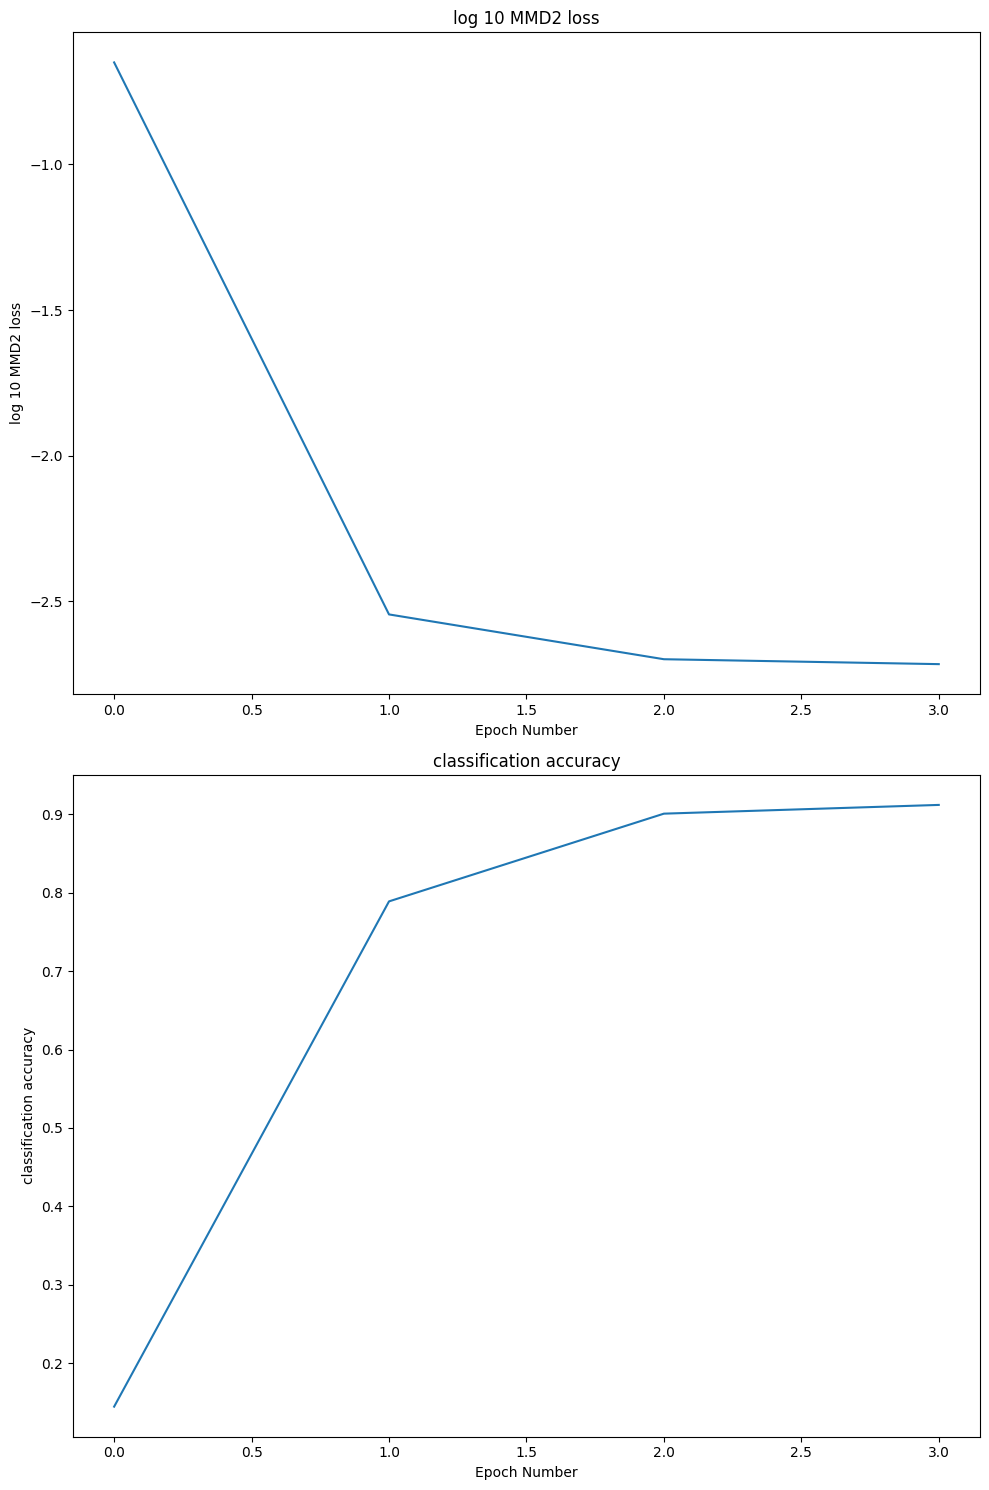

In [4]:
fig, ax = plt.subplots(2,1,figsize=(10,15))

plt.subplot(2,1,1)
plt.plot(np.log10(mmd_loss))
plt.xlabel('Epoch Number')
plt.ylabel('log 10 MMD2 loss')
plt.title('log 10 MMD2 loss')

plt.subplot(2,1,2)
plt.plot(acc_list)
plt.xlabel('Epoch Number')
plt.ylabel('classification accuracy')
plt.title('classification accuracy')

fig.tight_layout()
plt.savefig('training_loss.png')
plt.show()

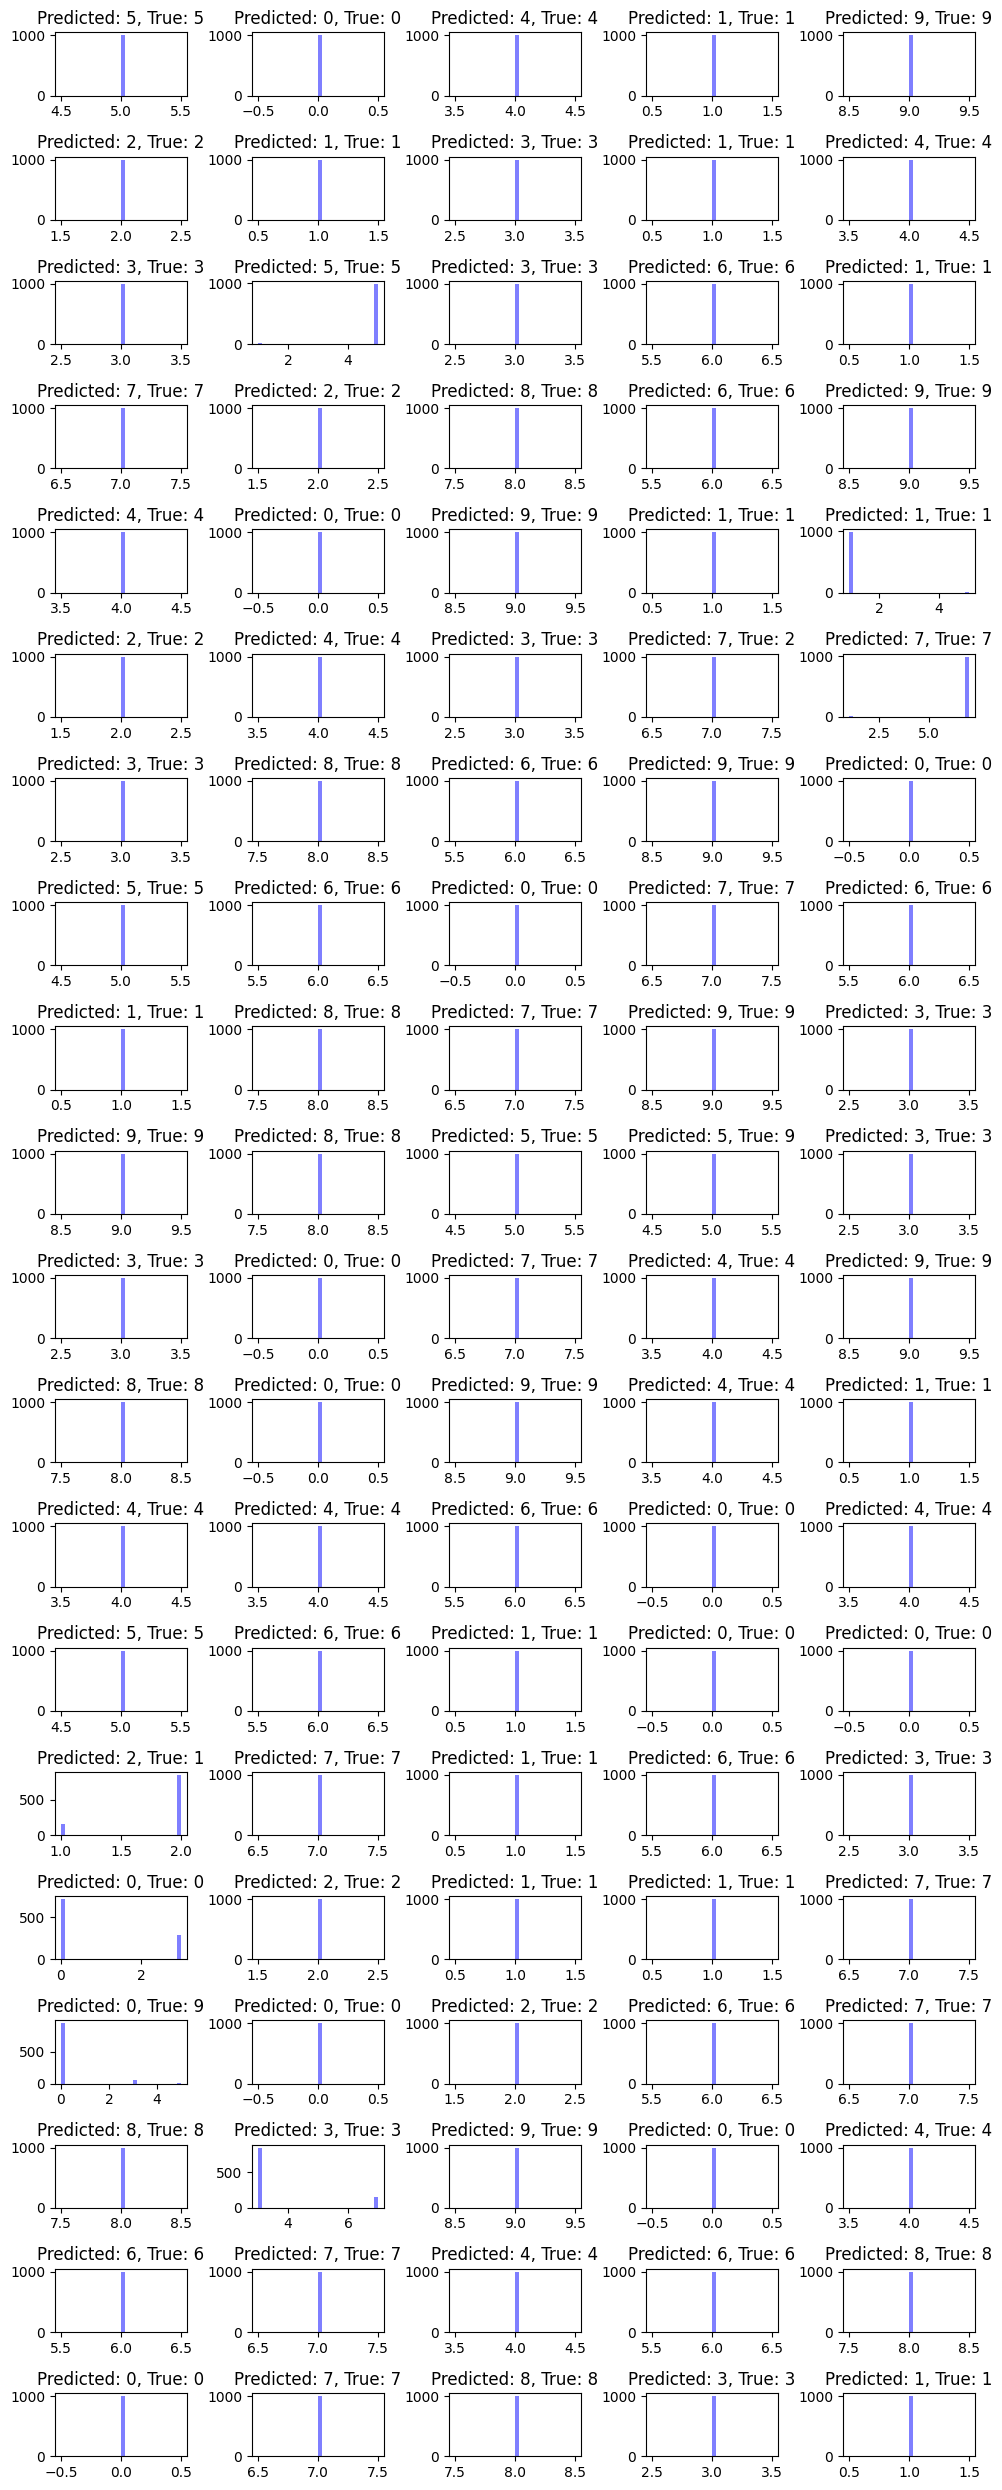

In [5]:
G_zy.eval()
fig, ax = plt.subplots(20,5,figsize=(10,25))

for i in range(100):
    xs, ys = train_ds[i]
    xs, ys = xs.to(device), ys.to(device)

    xs_rep = xs.repeat(1000,1).detach()

    Noise_fake = sample_noise(xs_rep.shape[0], noise_dimension, input_noise_type, input_var = input_noise_var).to(device).detach()
    with torch.no_grad():
        yhats = G_zy(torch.cat((xs_rep,Noise_fake),dim=1)).to(device).argmax(axis = 1)
    yhats_mode, _ = torch.mode(yhats.reshape(1000, 1).T, dim = 1)
    ys_true = ys.argmax(axis = 0).cpu()
    # Plot histogram
    plt.subplot(20,5,i+1)
    plt.hist(yhats.cpu().numpy(), bins=30, alpha=0.5, color='b')
    plt.title(f'Predicted: {yhats_mode.item()}, True: {ys_true}')
fig.tight_layout()
plt.savefig('training_results_02.png')
plt.show()

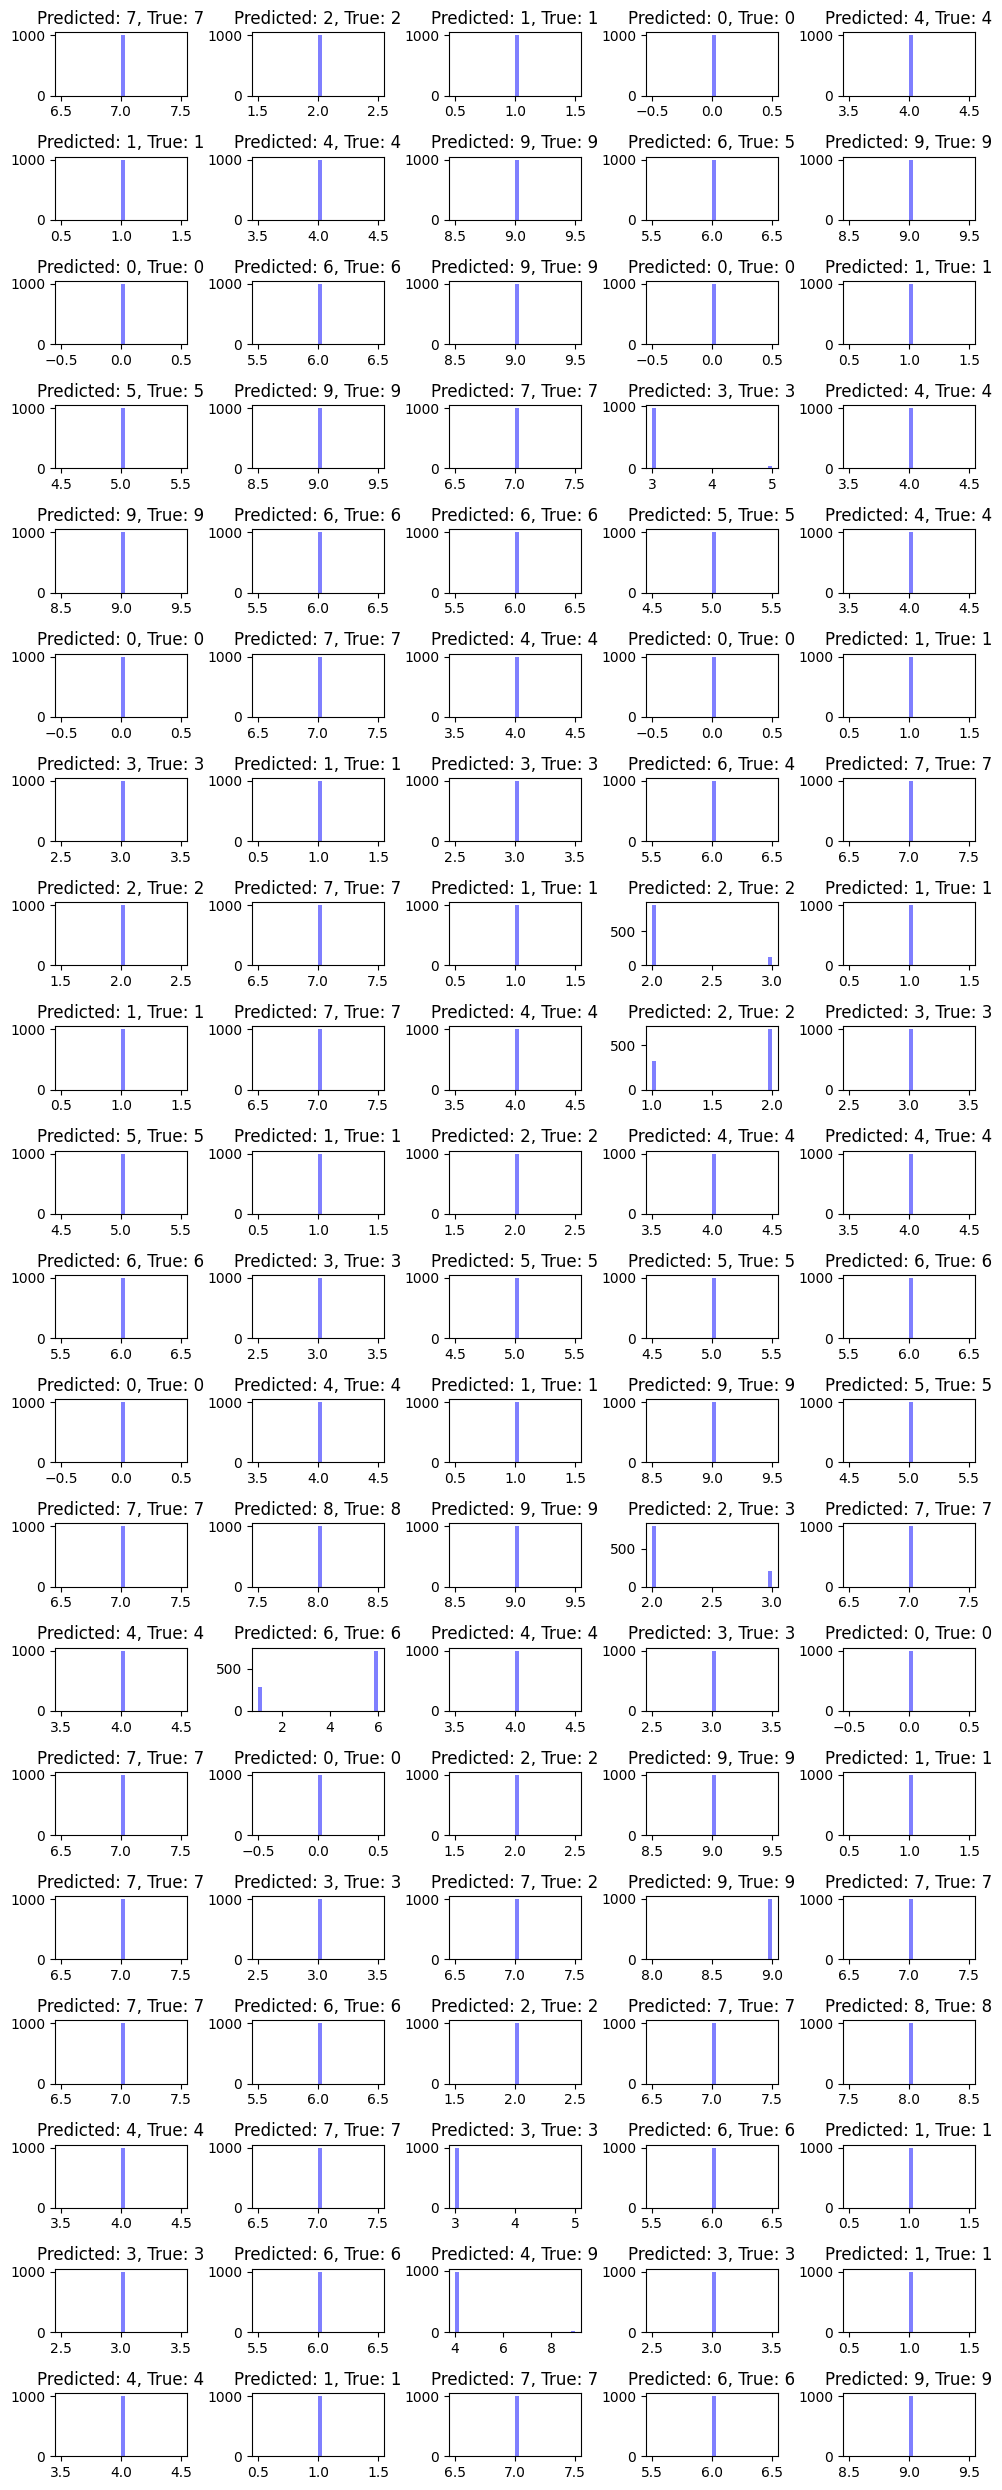

In [6]:
G_zy.eval()
fig, ax = plt.subplots(20,5,figsize=(10,25))

for i in range(100):
    xs, ys = test_ds[i]
    xs, ys = xs.to(device), ys.to(device)

    xs_rep = xs.repeat(1000,1).detach()

    Noise_fake = sample_noise(xs_rep.shape[0], noise_dimension, input_noise_type, input_var = input_noise_var).to(device).detach()
    with torch.no_grad():
        yhats = G_zy(torch.cat((xs_rep,Noise_fake),dim=1)).to(device).argmax(axis = 1)
    yhats_mode, _ = torch.mode(yhats.reshape(1000, 1).T, dim = 1)
    ys_true = ys.argmax(axis = 0).cpu()
    # Plot histogram
    plt.subplot(20,5,i+1)
    plt.hist(yhats.cpu().numpy(), bins=30, alpha=0.5, color='b')
    plt.title(f'Predicted: {yhats_mode.item()}, True: {ys_true}')
fig.tight_layout()
plt.savefig('training_results_02.png')
plt.show()